In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst
import xarray as xr

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [3]:
df = pd.read_csv('../kruschke_data/FruitflyDataReduced.csv', dtype={'CompanionNumber':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Longevity        125 non-null    int64   
 1   CompanionNumber  125 non-null    category
 2   Thorax           125 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 2.4 KB


In [4]:
df.groupby('CompanionNumber').head(2)

Longevity CompanionNumber  Thorax
0           35       Pregnant8    0.64
1           37       Pregnant8    0.68
25          40           None0    0.64
26          37           None0    0.70
50          46       Pregnant1    0.64
51          42       Pregnant1    0.68
75          21         Virgin1    0.68
76          40         Virgin1    0.68
100         16         Virgin8    0.64
101         19         Virgin8    0.64

In [5]:
# Count the number of records per nominal group
df.CompanionNumber.value_counts()


None0        25
Pregnant1    25
Pregnant8    25
Virgin1      25
Virgin8      25
Name: CompanionNumber, dtype: int64

In [6]:
x = df.CompanionNumber
y = df.Longevity
mu_y = y.mean()
sigma_y = y.std()

In [7]:
model, idata = bst.metric_outcome_one_nominal_predictor(x, y, mu_y, sigma_y, n_draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, a0, a, sigma_y]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 40 seconds.


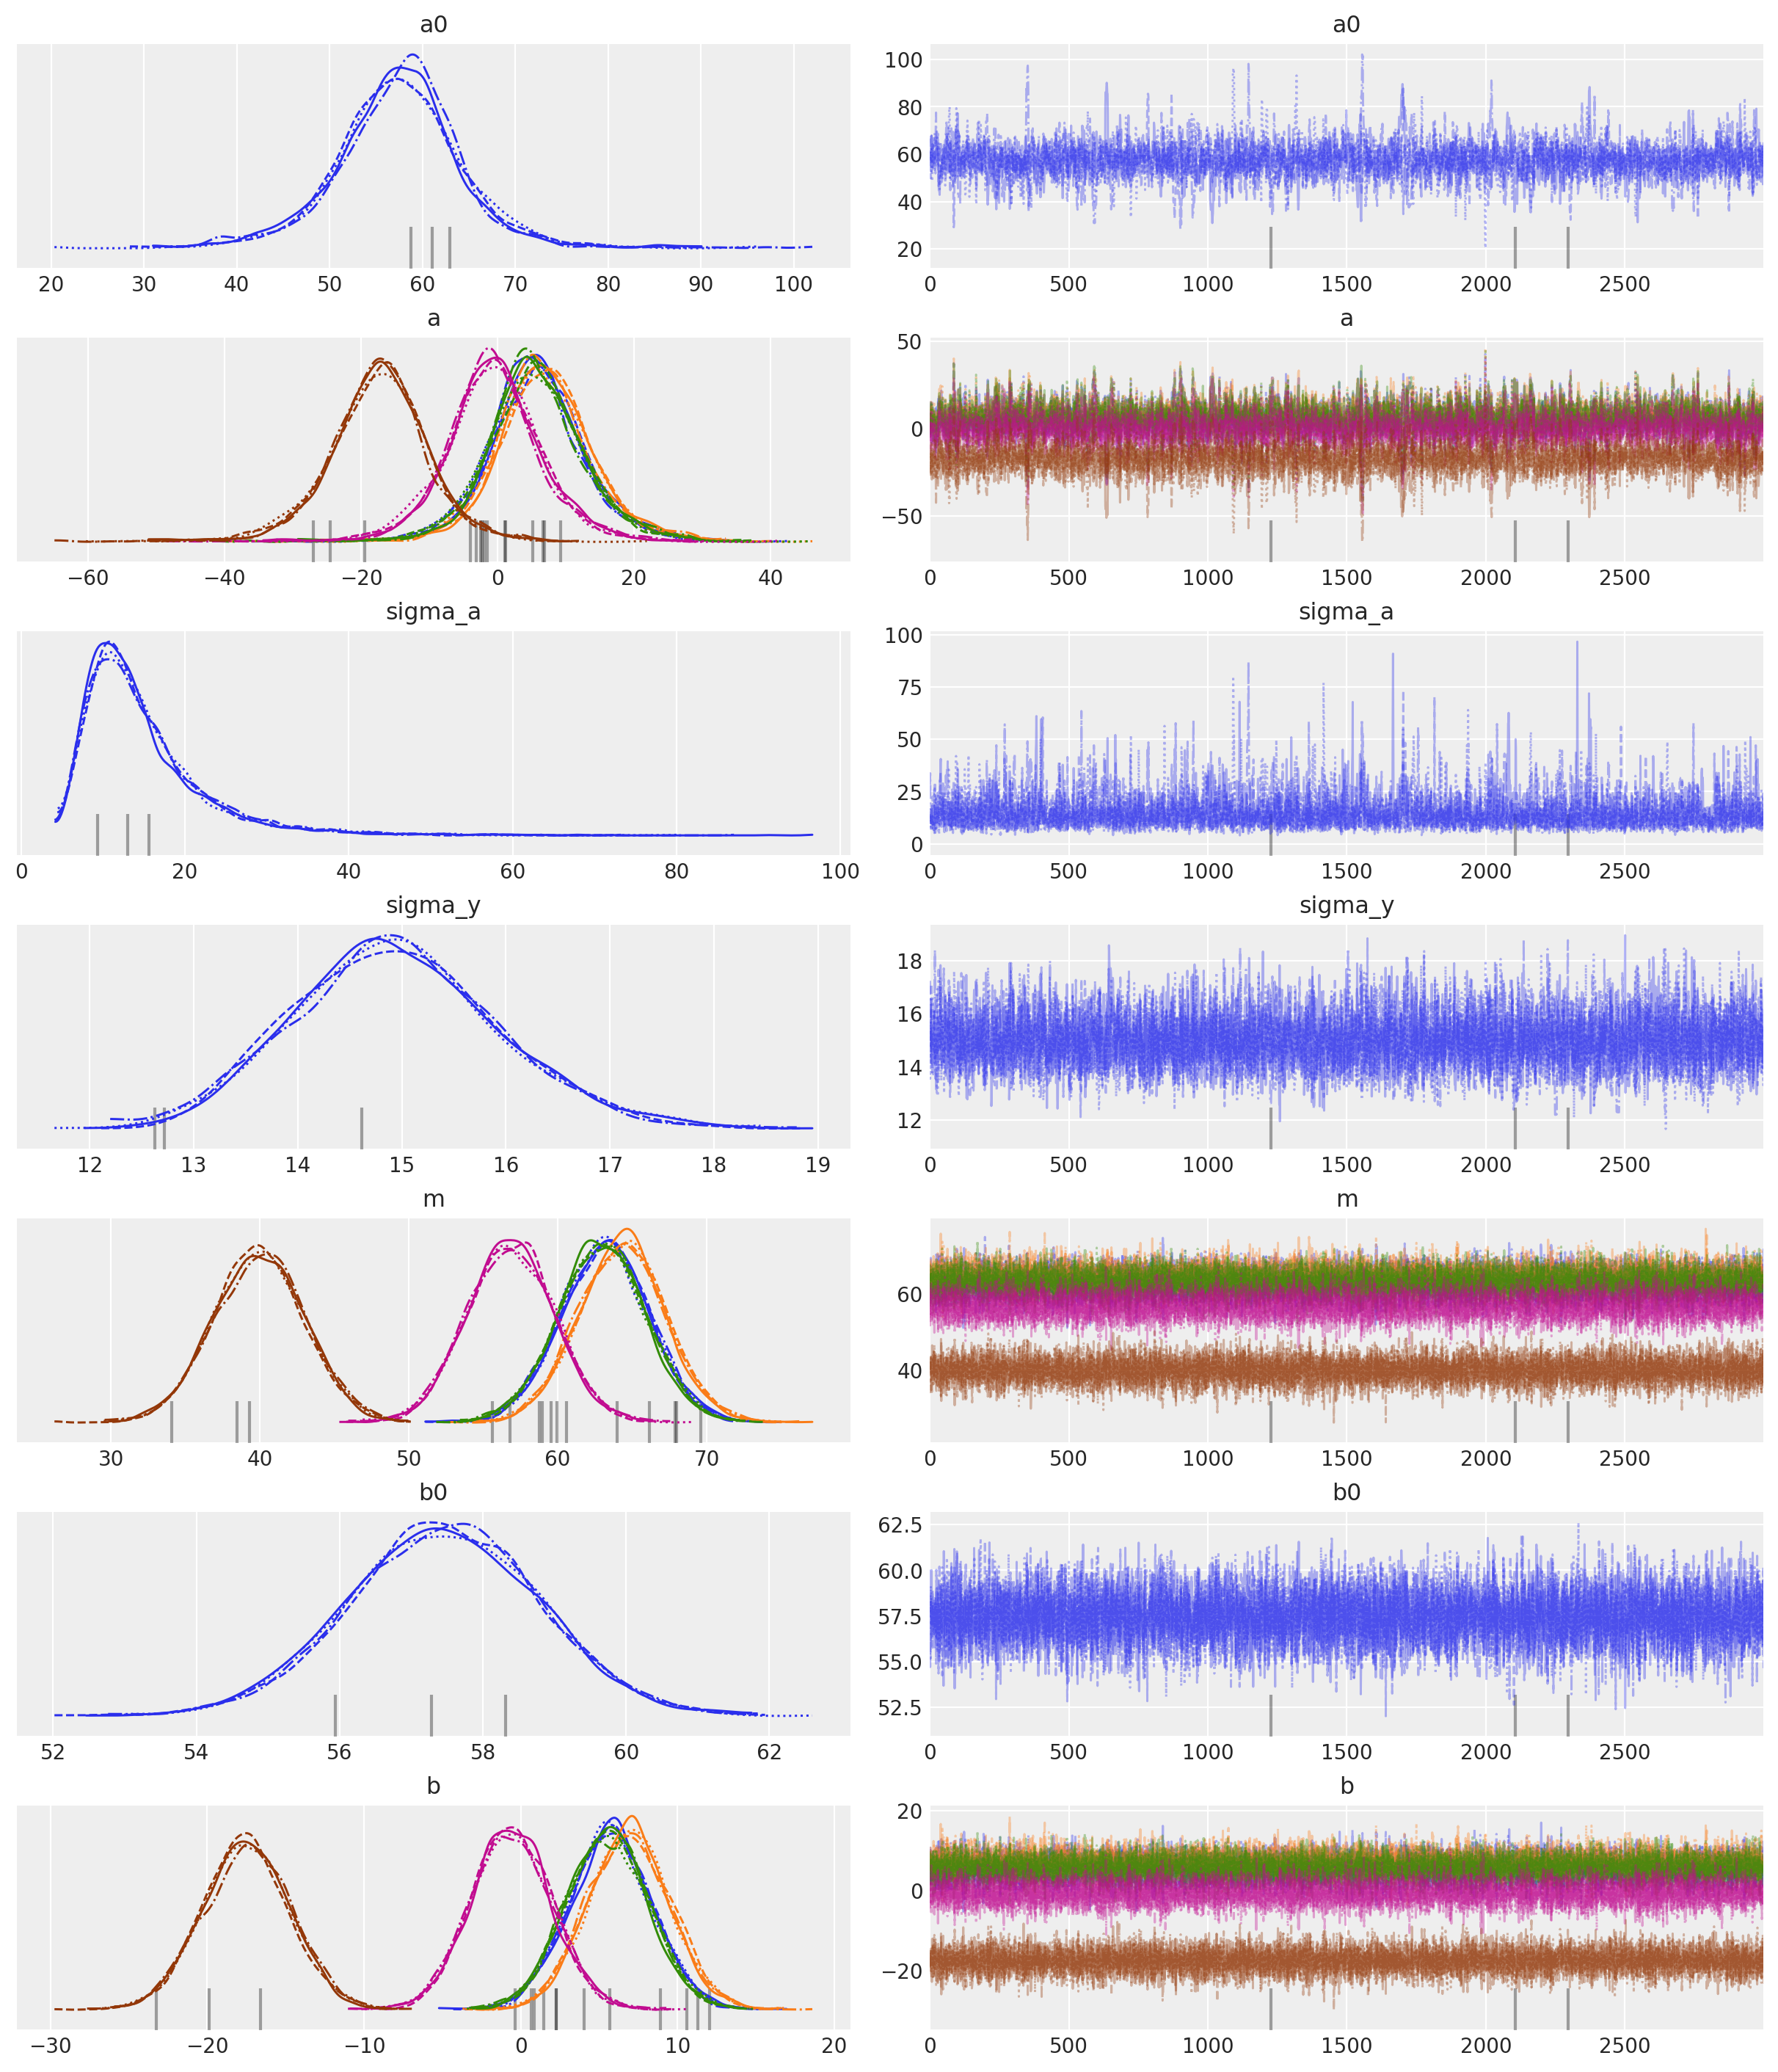

In [8]:
az.plot_trace(idata);

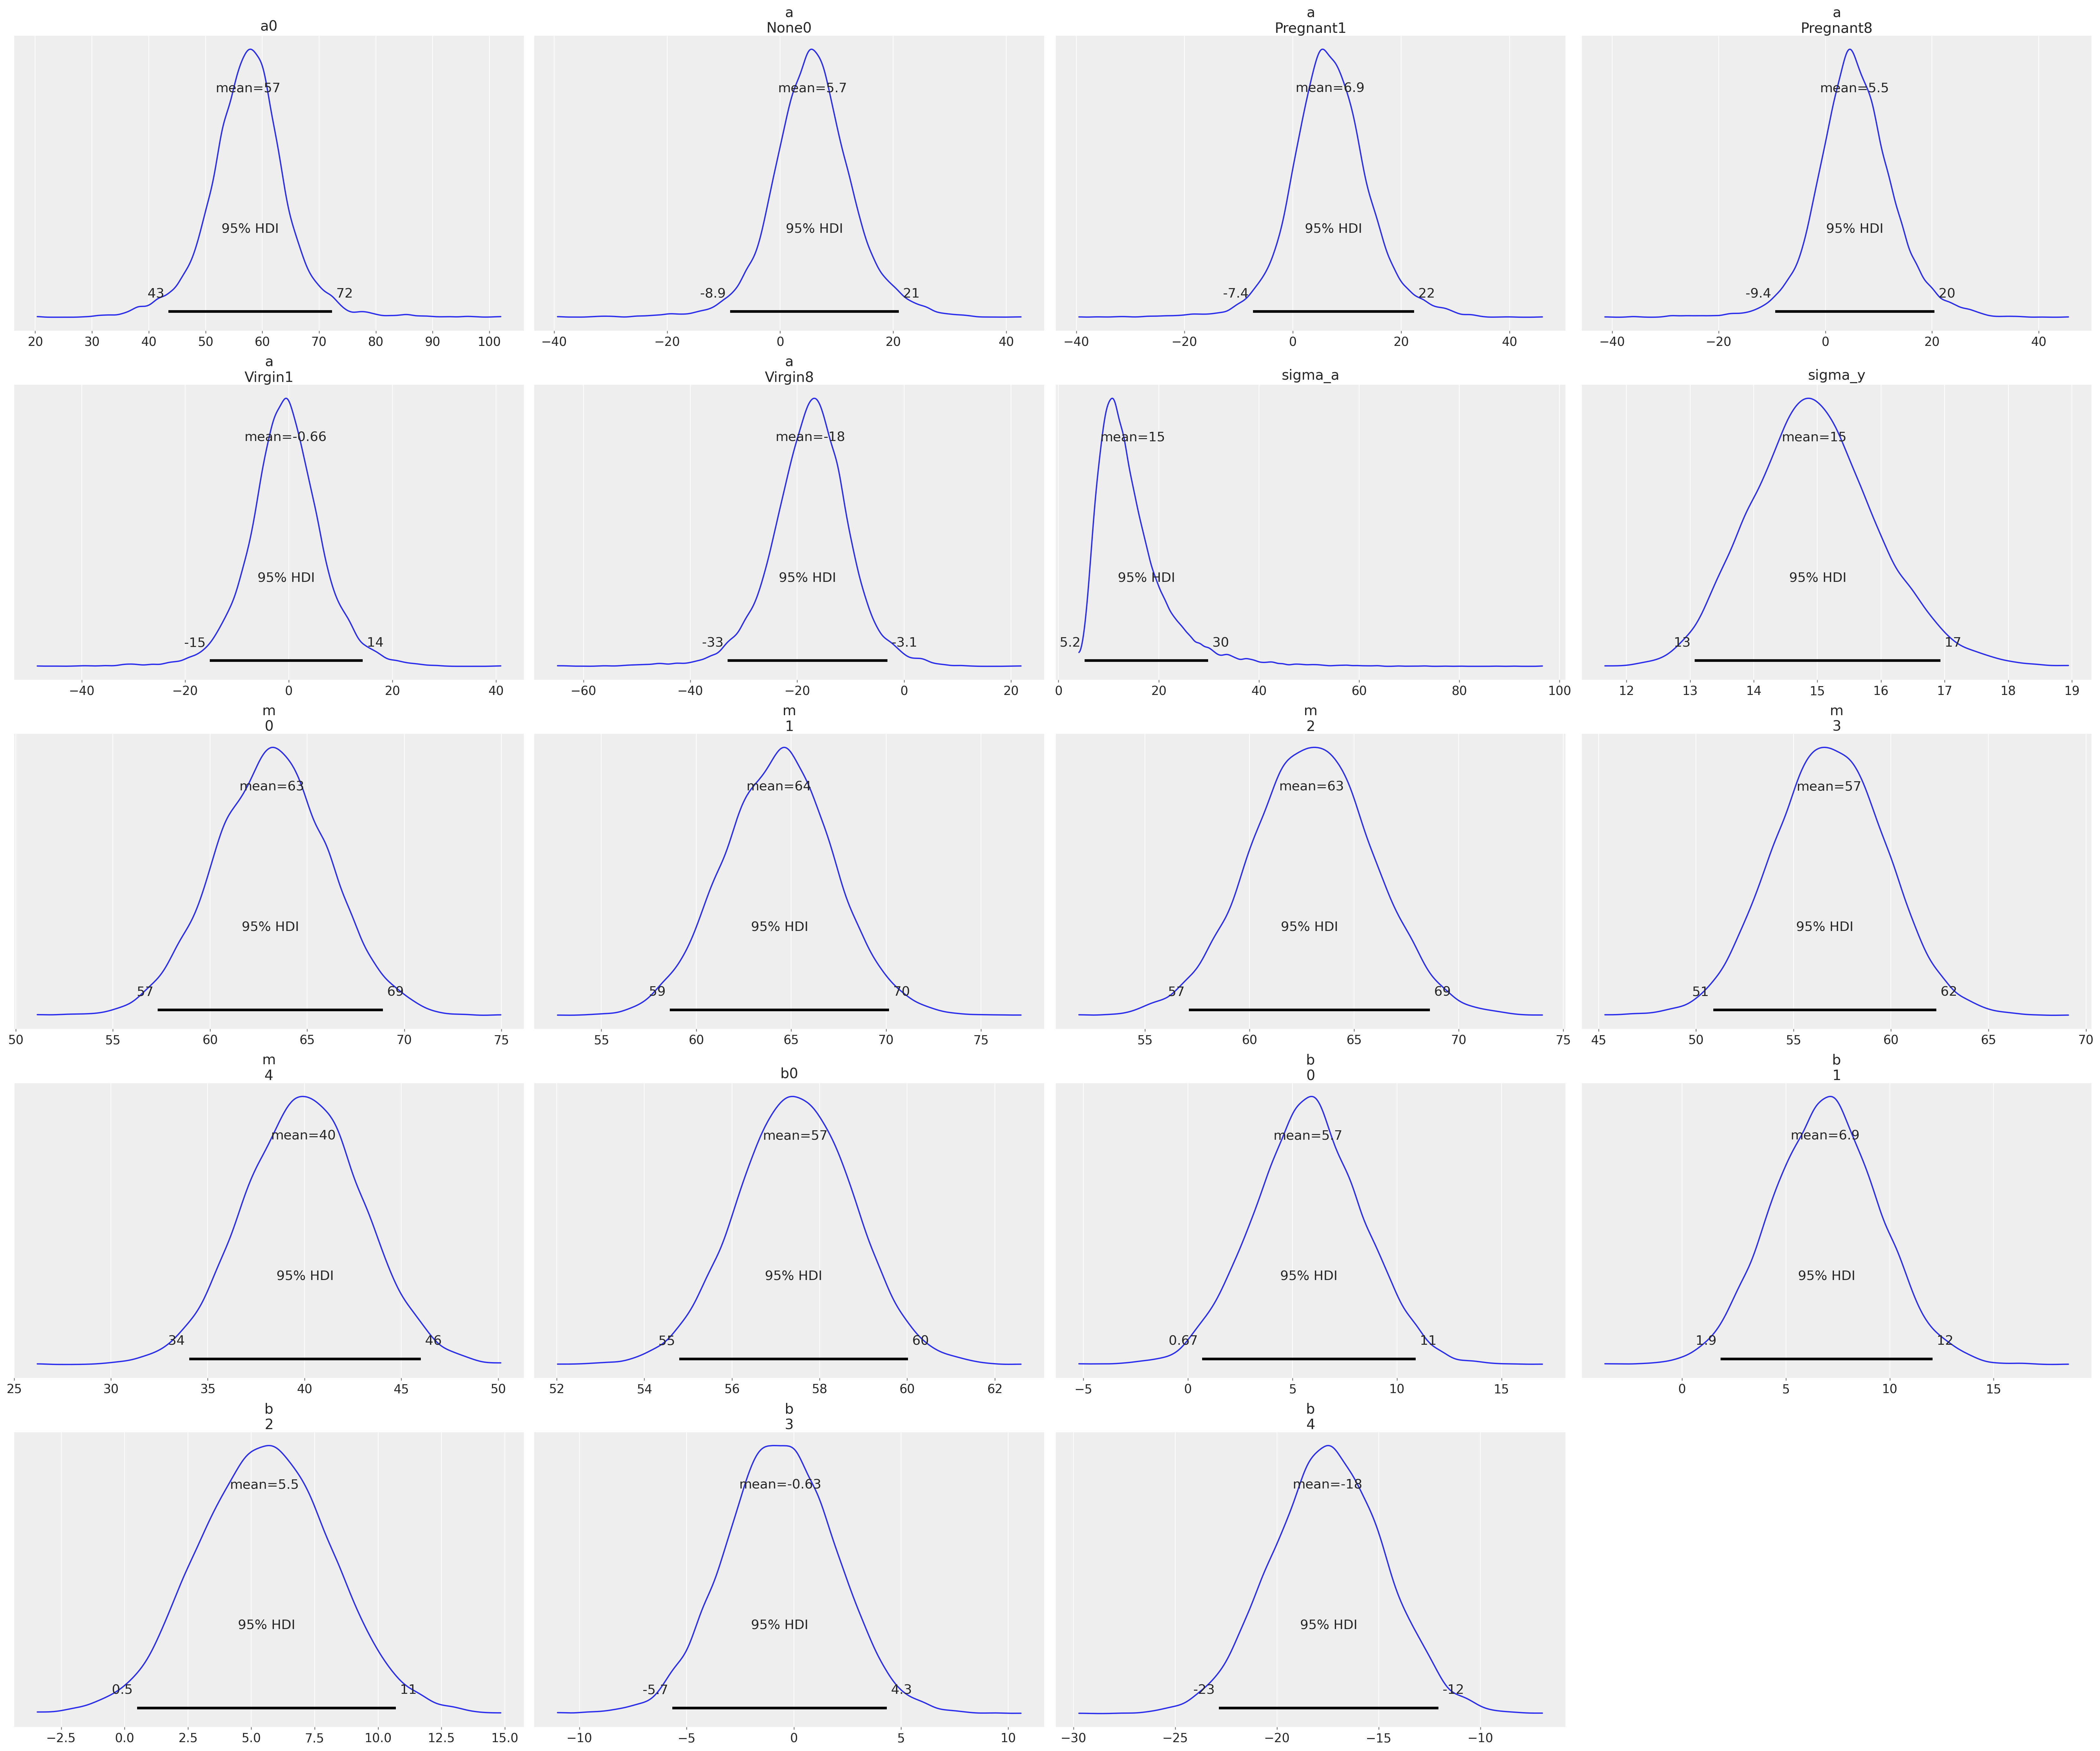

In [9]:
az.plot_posterior(idata);

In [10]:
post = idata.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 3000, groups: 5, m_dim_0: 5, b_dim_0: 5)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
  * groups   (groups) <U9 'None0' 'Pregnant1' 'Pregnant8' 'Virgin1' 'Virgin8'
  * m_dim_0  (m_dim_0) int64 0 1 2 3 4
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4
Data variables:
    a0       (chain, draw) float64 65.89 67.4 66.0 65.05 ... 46.36 56.59 66.24
    a        (chain, draw, groups) float64 -0.9922 -0.8198 ... -7.814 -20.97
    sigma_a  (chain, draw) float64 12.98 10.97 11.7 9.935 ... 13.84 11.7 18.85
    sigma_y  (chain, draw) float64 15.59 15.74 16.54 15.5 ... 15.2 15.01 14.7
    m        (chain, draw, m_dim_0) float64 64.89 65.07 61.45 ... 58.42 45.27
    b0       (chain, draw) float64 58.28 59.97 58.31 59.5 ... 57.61 55.89 58.91
    b        (chain, draw, b_dim_0) float64 6.616 6.789 3.173 ... -0.4814 -13.64
Attributes:
    created_at:                 2022-11-11T19:07:14.009057
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              40.00468611717224
    tuning_steps:               1000

In [11]:
stacked = az.extract(post)
stacked

<xarray.Dataset>
Dimensions:  (sample: 12000, groups: 5, m_dim_0: 5, b_dim_0: 5)
Coordinates:
  * groups   (groups) <U9 'None0' 'Pregnant1' 'Pregnant8' 'Virgin1' 'Virgin8'
  * m_dim_0  (m_dim_0) int64 0 1 2 3 4
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 2993 2994 2995 2996 2997 2998 2999
Data variables:
    a0       (sample) float64 65.89 67.4 66.0 65.05 ... 50.88 46.36 56.59 66.24
    a        (groups, sample) float64 -0.9922 0.8215 -3.095 ... -19.78 -20.97
    sigma_a  (sample) float64 12.98 10.97 11.7 9.935 ... 12.95 13.84 11.7 18.85
    sigma_y  (sample) float64 15.59 15.74 16.54 15.5 ... 15.46 15.2 15.01 14.7
    m        (m_dim_0, sample) float64 64.89 68.22 62.91 ... 38.09 36.81 45.27
    b0       (sample) float64 58.28 59.97 58.31 59.5 ... 57.21 57.61 55.89 58.91
    b        (b_dim_0, sample) float64 6.616 8.248 4.599 ... -19.07 -13.64
Attributes:
    created_at:                 2022-11-11T19:07:14.009057
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              40.00468611717224
    tuning_steps:               1000

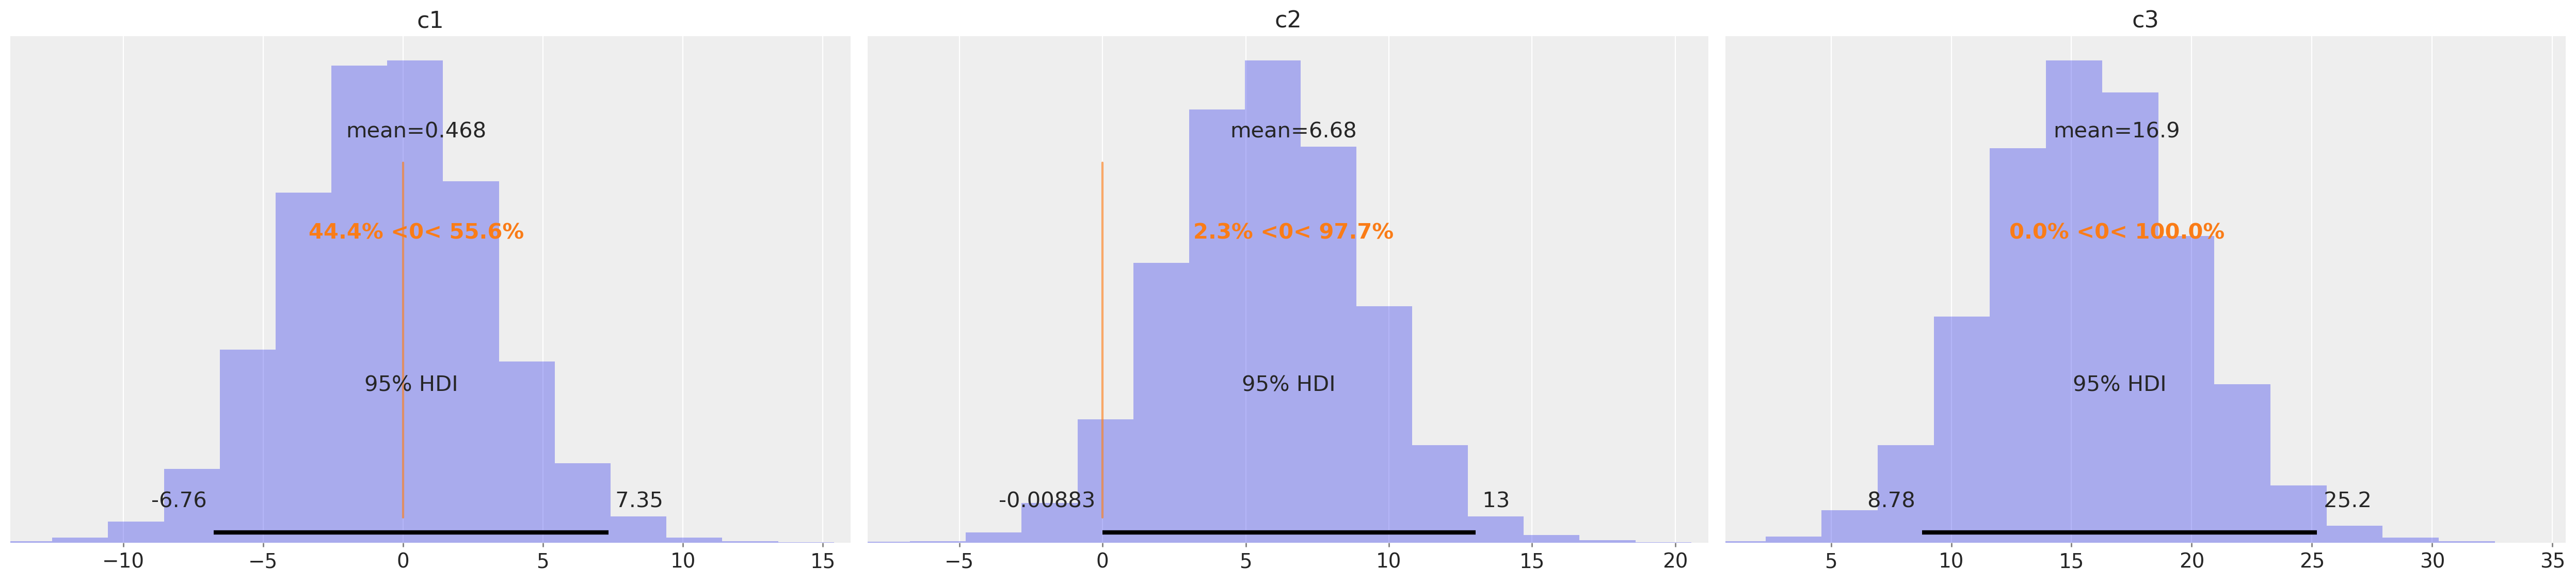

In [12]:
# Contrasts
contrasts = dict(c1=(stacked.a.sel(groups=["Pregnant1", "Pregnant8"]).mean(axis=0) - stacked.a.sel(groups="None0")).values,
             c2=(stacked.a.sel(groups=["Pregnant1", "Pregnant8", "None0"]).mean(axis=0) - stacked.a.sel(groups="Virgin1")).values,
             c3=(stacked.a.sel(groups=["Virgin1"]).values - stacked.a.sel(groups=["Virgin8"]).values).flatten())

az.plot_posterior(contrasts, kind="hist", round_to=3, ref_val=0);

In [13]:
stacked.a.sel(groups=["None0"])

<xarray.DataArray 'a' (groups: 1, sample: 12000)>
array([[-0.99223871,  0.82147629, -3.09454085, ..., 19.20873293,
         5.90975685, -1.57300338]])
Coordinates:
  * groups   (groups) <U9 'None0'
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 2993 2994 2995 2996 2997 2998 2999

### ANCOVA

In [14]:
y = df.Longevity
mu_y = y.mean()
sigma_y = y.std()
x_nom = df.CompanionNumber
x_met = df.Thorax
mu_x_met = x_met.mean()
sigma_x_met = x_met.std()

In [15]:
model2, idata2 = bst.metric_outcome_one_nominal_one_metric_predictor(x, x_met, y, mu_x_met, mu_y, sigma_x_met, sigma_y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, a0, a, a_met, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [16]:
stacked2 = az.extract(idata2.posterior)
contrasts2 = {"Pregnant1Pregnant8 vs None0": 
              (stacked2.a.sel(groups=["Pregnant1", "Pregnant8"]).mean(axis=0) - stacked2.a.sel(groups="None0")).values,
              "Pregnant1Pregnant8None0 vs Virgin1":
              (stacked2.a.sel(groups=["Pregnant1", "Pregnant8", "None0"]).mean(axis=0) - stacked2.a.sel(groups="Virgin1")).values,
             "Virgin1 vs Virgin8":
              (stacked2.a.sel(groups=["Virgin1"]).values - stacked2.a.sel(groups=["Virgin8"]).values).flatten()}

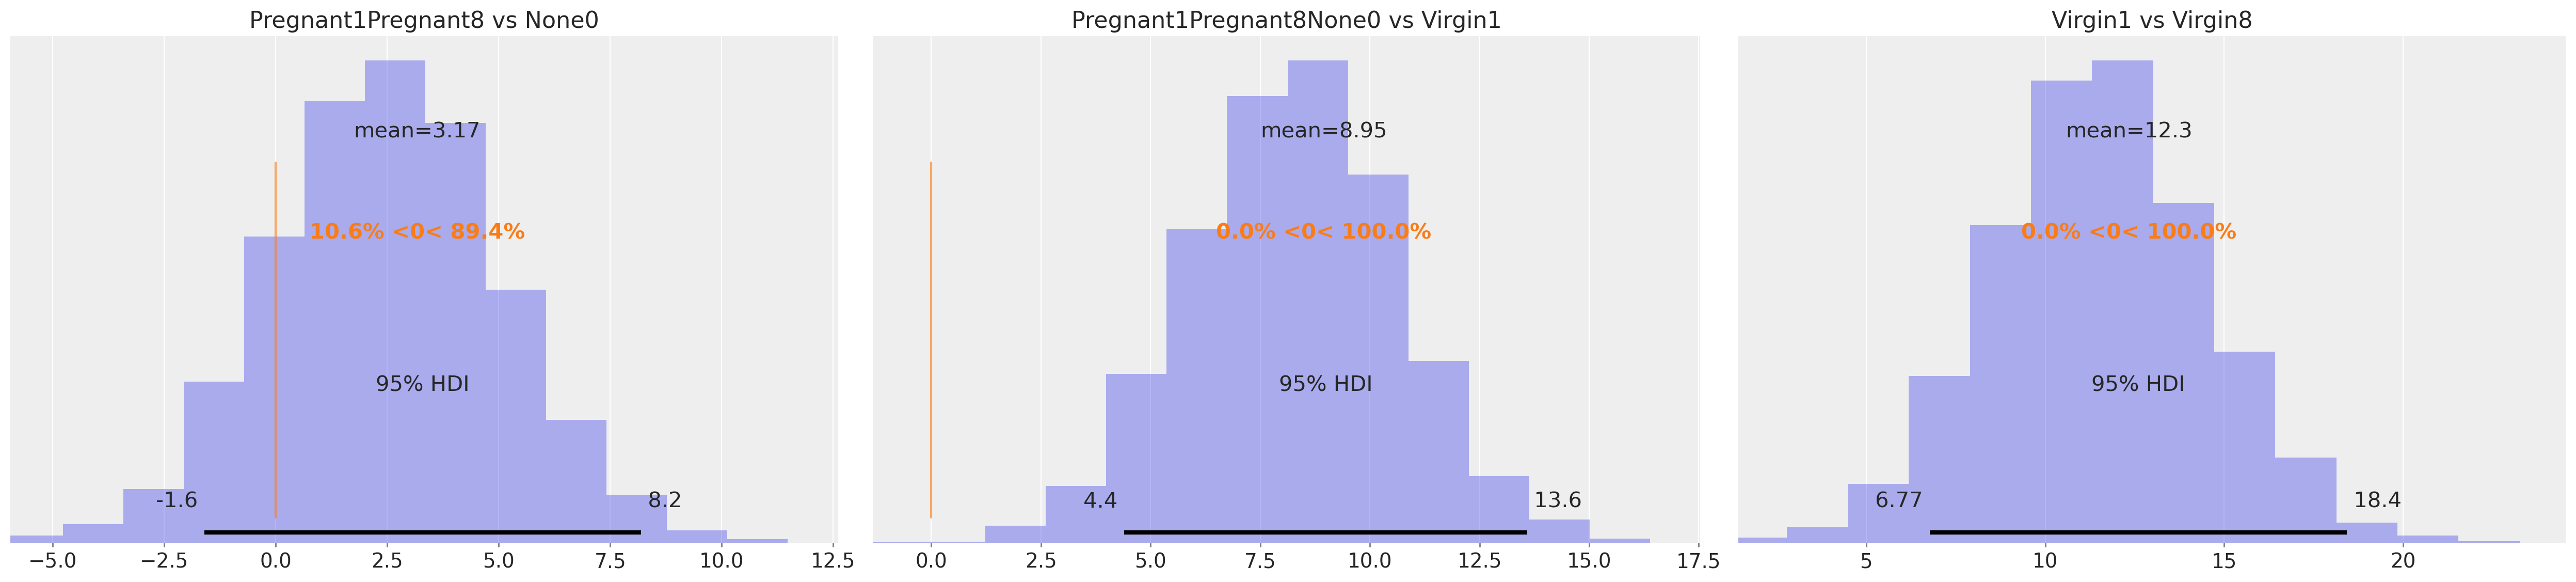

In [17]:
az.plot_posterior(contrasts2, kind="hist", round_to=3, ref_val=0);

### Robust ANOVA with Heterogeneous Variances 

In [18]:
df2 = pd.read_csv('../kruschke_data/NonhomogVarData.csv')  # Not including the dtype argument to make sure my function works
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   96 non-null     object 
 1   Y       96 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [19]:
df2.groupby('Group').head(3)

Group           Y
0      A   97.770214
1      A   99.919872
2      A   92.372917
24     B   98.246778
25     B   98.736006
26     B   98.722708
48     C  102.432580
49     C  102.198665
50     C  103.052658
72     D   97.561346
73     D   92.912256
74     D   96.500329

In [20]:
y = df2.Y
x = df2.Group
# xlevels = df2.Group.cat.categories
# NxLvl = len(xlevels) 
mu_y = y.mean()
sigma_y = y.std()

In [21]:
model3, idata3 = bst.robust_anova(x, y, mu_y, sigma_y, n_draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 27500
Interrupted at 27,499 [13%]: Average Loss = 32,898
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, a0, a, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 150 seconds.


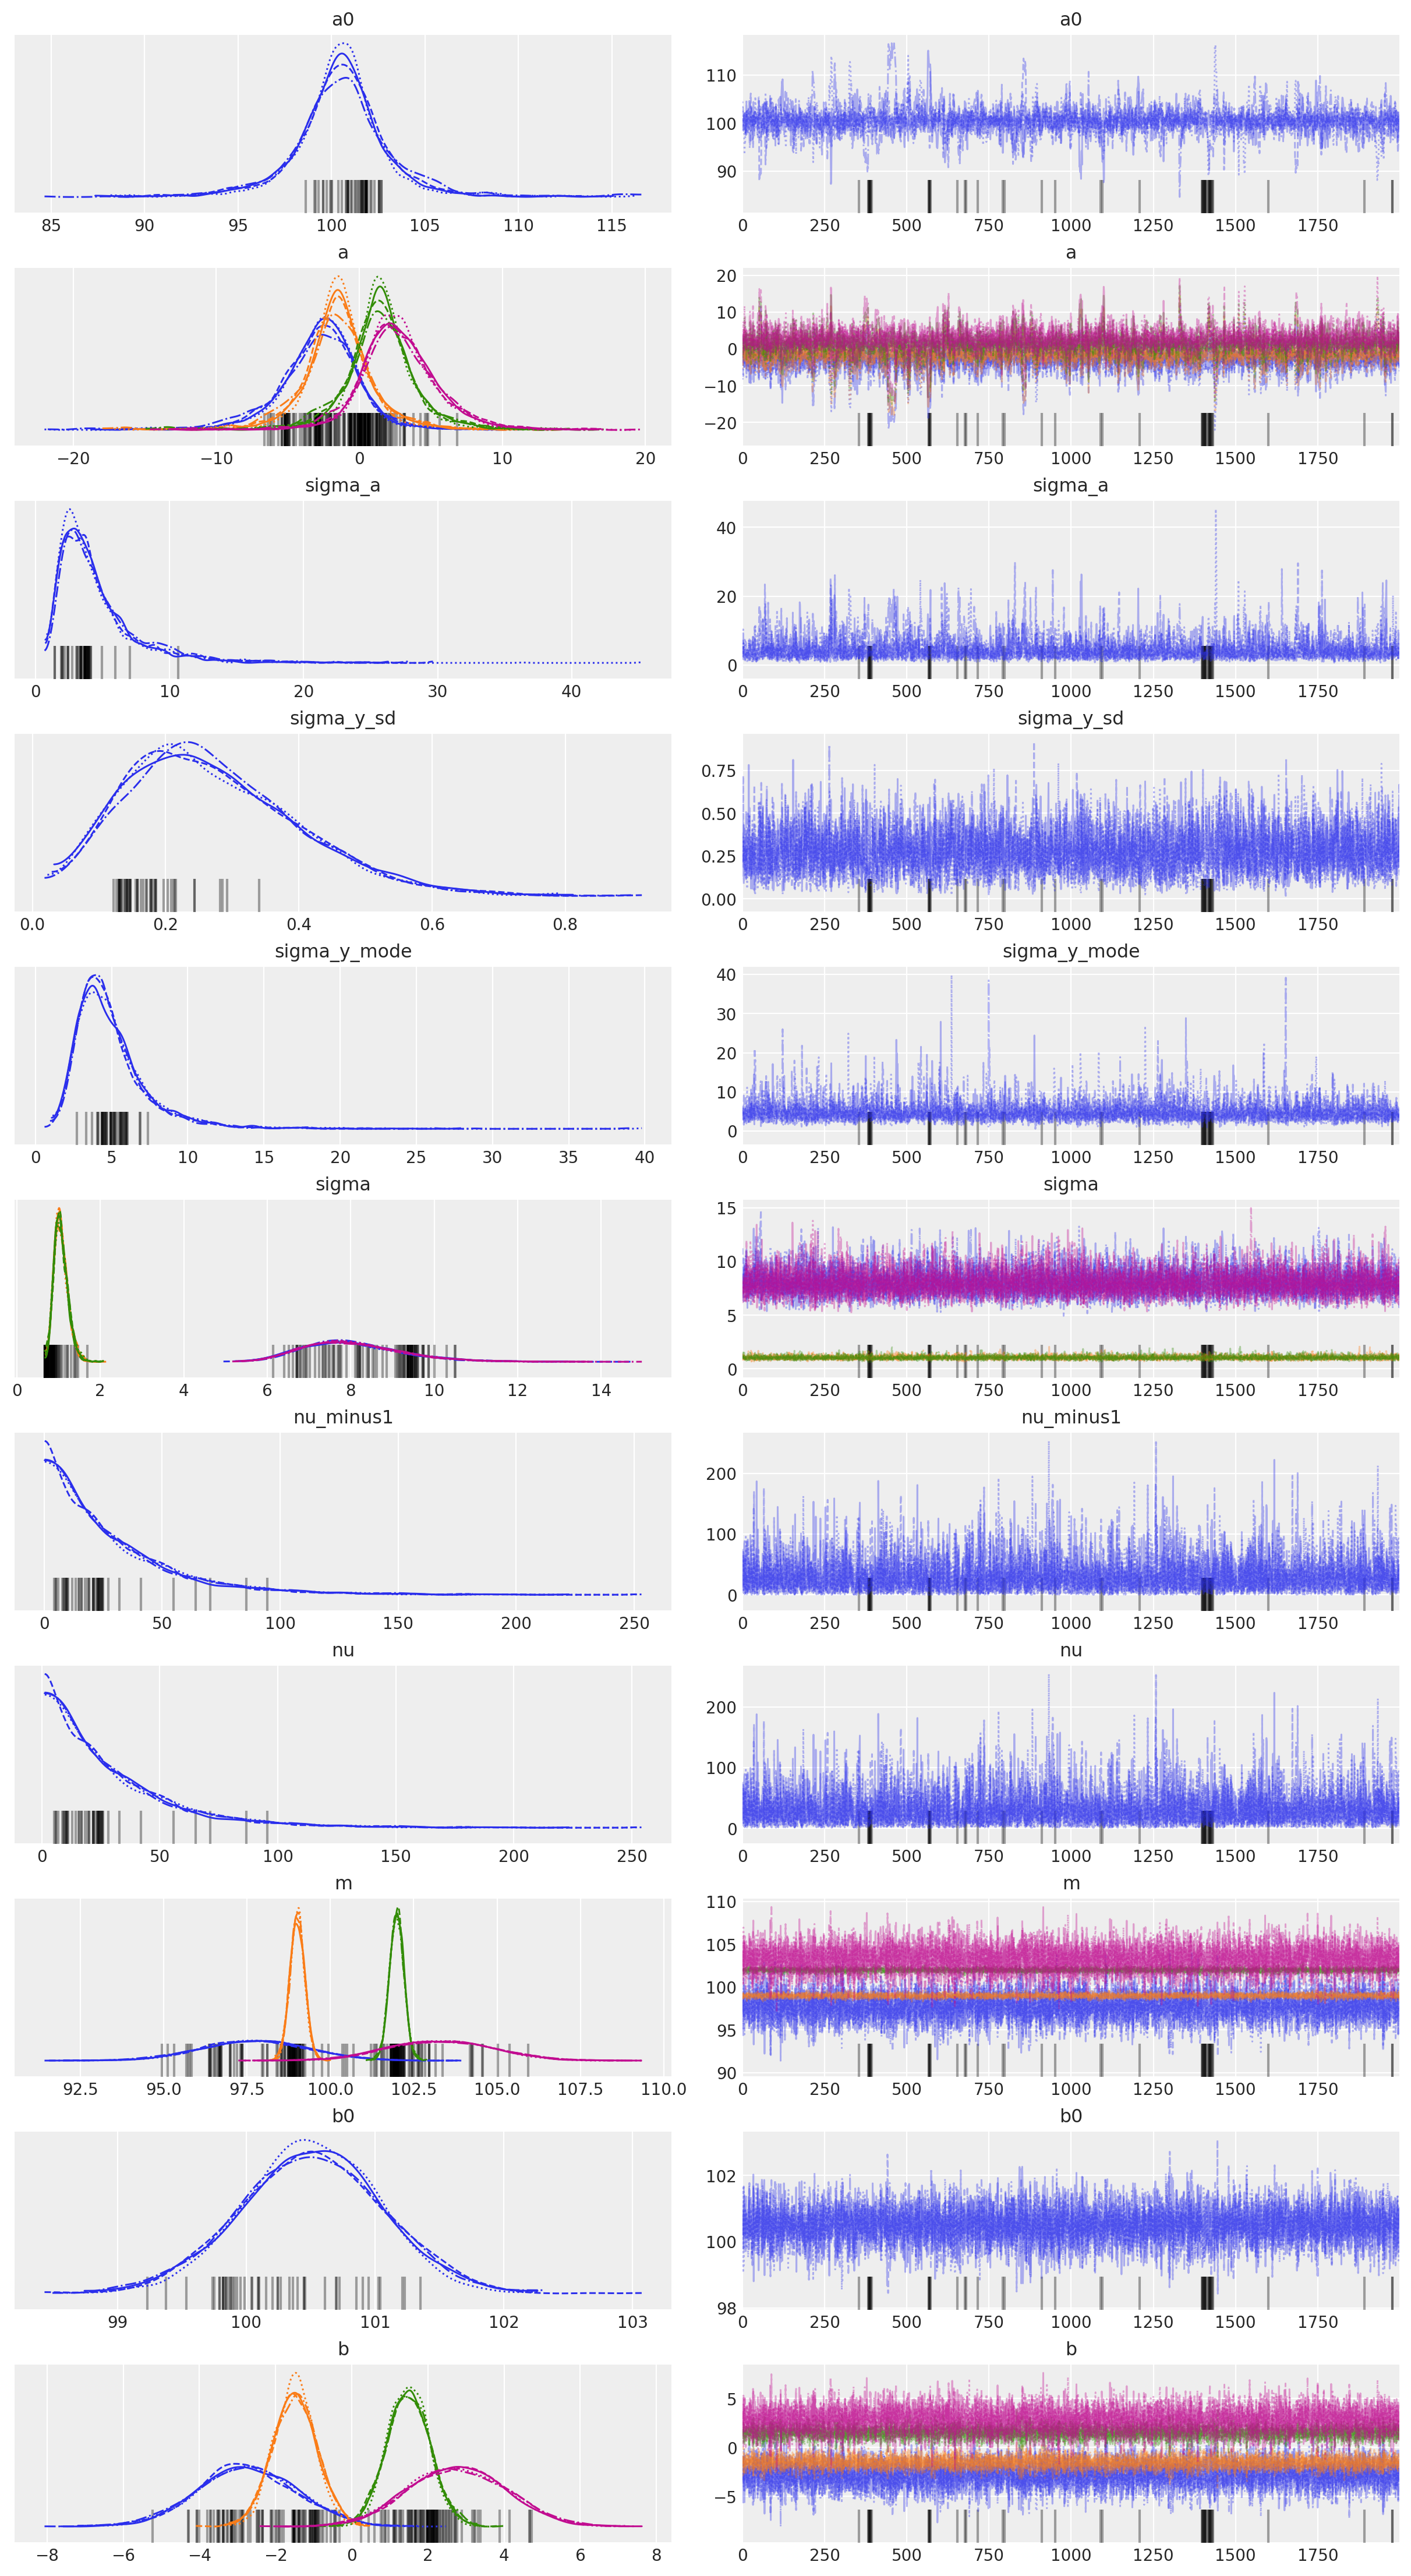

In [22]:
az.plot_trace(idata3);